In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from fish_proc.utils.np_mp import parallel_to_single
from tqdm import tqdm
from scipy.stats import ranksums, wilcoxon
from statsmodels.multivariate.manova import MANOVA

from utils import *
from brain_seg import brain_seg_factor
from factor import thres_factor_
from brain_segment_vis import *
from swim_ephys import *
from kernel_fit import *
from scipy.stats import spearmanr
%load_ext autoreload
%autoreload 2
%matplotlib inline

df = pd.read_csv('../Processing/data_list.csv')
row = df.iloc[15]
save_root = row['save_dir']+'/'

_ = np.load(save_root+'cell_dff.npz', allow_pickle=True)
A = _['A']
A_loc = _['A_loc']
dFF = _['dFF'].astype('float')
_ = None

### mask cells

In [2]:
brain_map = np.load(save_root+'Y_ave.npy').astype('float').squeeze()
A_center = np.load(save_root+'cell_center.npy')
A_center_grid = np.round(A_center).astype('int')
cells_in_mask = []

for n_layer in range(brain_map.shape[0]):
    layer_ = A_center[:, 0]==n_layer
    cell_ids = np.where(layer_)[0]
    mask_ = brain_map[n_layer]>2
    y = A_center_grid[cell_ids, 2]
    x = A_center_grid[cell_ids, 1]
    num_cells = len(cell_ids)
    in_mask_ = np.zeros(num_cells).astype('bool')
    for n in range(num_cells):
        in_mask_[n] = mask_[x[n], y[n]]
    cells_in_mask.append(cell_ids[in_mask_])
cells_in_mask = np.concatenate(cells_in_mask)
A_center = A_center[cells_in_mask]
dFF = dFF[cells_in_mask]

### Precomptued neuron selectivity

In [3]:
_ = np.load(save_root+'cell_type_stats_sensory.npz', allow_pickle=True)
cell_sensory_stats=_['cell_sensory_stats']
_ = np.load(save_root+'cell_type_stats_pulse_motor.npz', allow_pickle=True)
cell_pulse_motor_stats=_['cell_pulse_motor_stats']
_ = np.load(save_root+'cell_type_stats_sm.npz', allow_pickle=True)
cell_sm_stats=_['cell_sm_stats']
_ = np.load(save_root+'cell_type_stats_motor.npz', allow_pickle=True)
cell_motor_stats=_['cell_motor_stats']
_ = np.load(save_root+'cell_comp_pulse_motor_stats_.npz', allow_pickle=True)
cell_comp_pulse_motor_stats=_['cell_comp_pulse_motor_stats']

## Sensory neurons

In [4]:
num_cells = dFF.shape[0]
pulse_ave_sel = np.zeros(num_cells).astype('bool')
pulse_vec_sel = np.zeros(num_cells).astype('bool')
pulse_manova_sel = np.zeros(num_cells).astype('bool')
pulse_ave_sel_baseline = np.ones(num_cells).astype('bool')

for n in range(num_cells):
    pulse_ave_sel[n] = cell_sensory_stats[n][0][0]<0.05
    pulse_vec_sel[n] = (cell_sensory_stats[n][1][0][3:]<0.05).sum()>=3
#     pulse_ave_sel_baseline[n] = (cell_sensory_stats[n][1][2][2:]>0.1).sum()>=4
    if cell_sensory_stats[n][2] is not None:
        pulse_manova_sel[n] = cell_sensory_stats[n][2]['Pr > F'].max()<0.05

In [5]:
pulse_resp = np.zeros((num_cells, 7))
nopulse_resp = np.zeros((num_cells, 7))

for n in range(num_cells):
    pulse_resp[n] = cell_sensory_stats[n][3]
    nopulse_resp[n] = cell_sensory_stats[n][4]

In [6]:
(pulse_vec_sel & pulse_ave_sel_baseline).sum()

2879

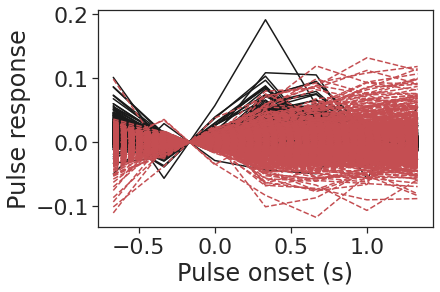

In [7]:
plt.plot(np.arange(-2,5)/3, pulse_resp[pulse_vec_sel & pulse_ave_sel_baseline].T, '-k')
plt.plot(np.arange(-2,5)/3, nopulse_resp[pulse_vec_sel & pulse_ave_sel_baseline].T, '--r')
plt.ylabel('Pulse response')
plt.xlabel('Pulse onset (s)')
plt.show()

In [8]:
pulse_motor_ave_sel = np.zeros(num_cells).astype('bool')
pulse_motor_vec_sel = np.zeros(num_cells).astype('bool')
pulse_motor_manova_sel = np.zeros(num_cells).astype('bool')
pulse_motor_ave_sel_baseline = np.ones(num_cells).astype('bool')

for n in range(num_cells):
    pulse_motor_ave_sel[n] = cell_pulse_motor_stats[n][0][0]<0.05
    pulse_motor_vec_sel[n] = (cell_pulse_motor_stats[n][1][0][3:]<0.05).sum()>=3
#     pulse_motor_ave_sel_baseline[n] = (cell_pulse_motor_stats[n][1][2][2:]>0.1).sum()>=5
    if cell_pulse_motor_stats[n][2] is not None:
        pulse_motor_manova_sel[n] = cell_pulse_motor_stats[n][2]['Pr > F'].max()<0.05

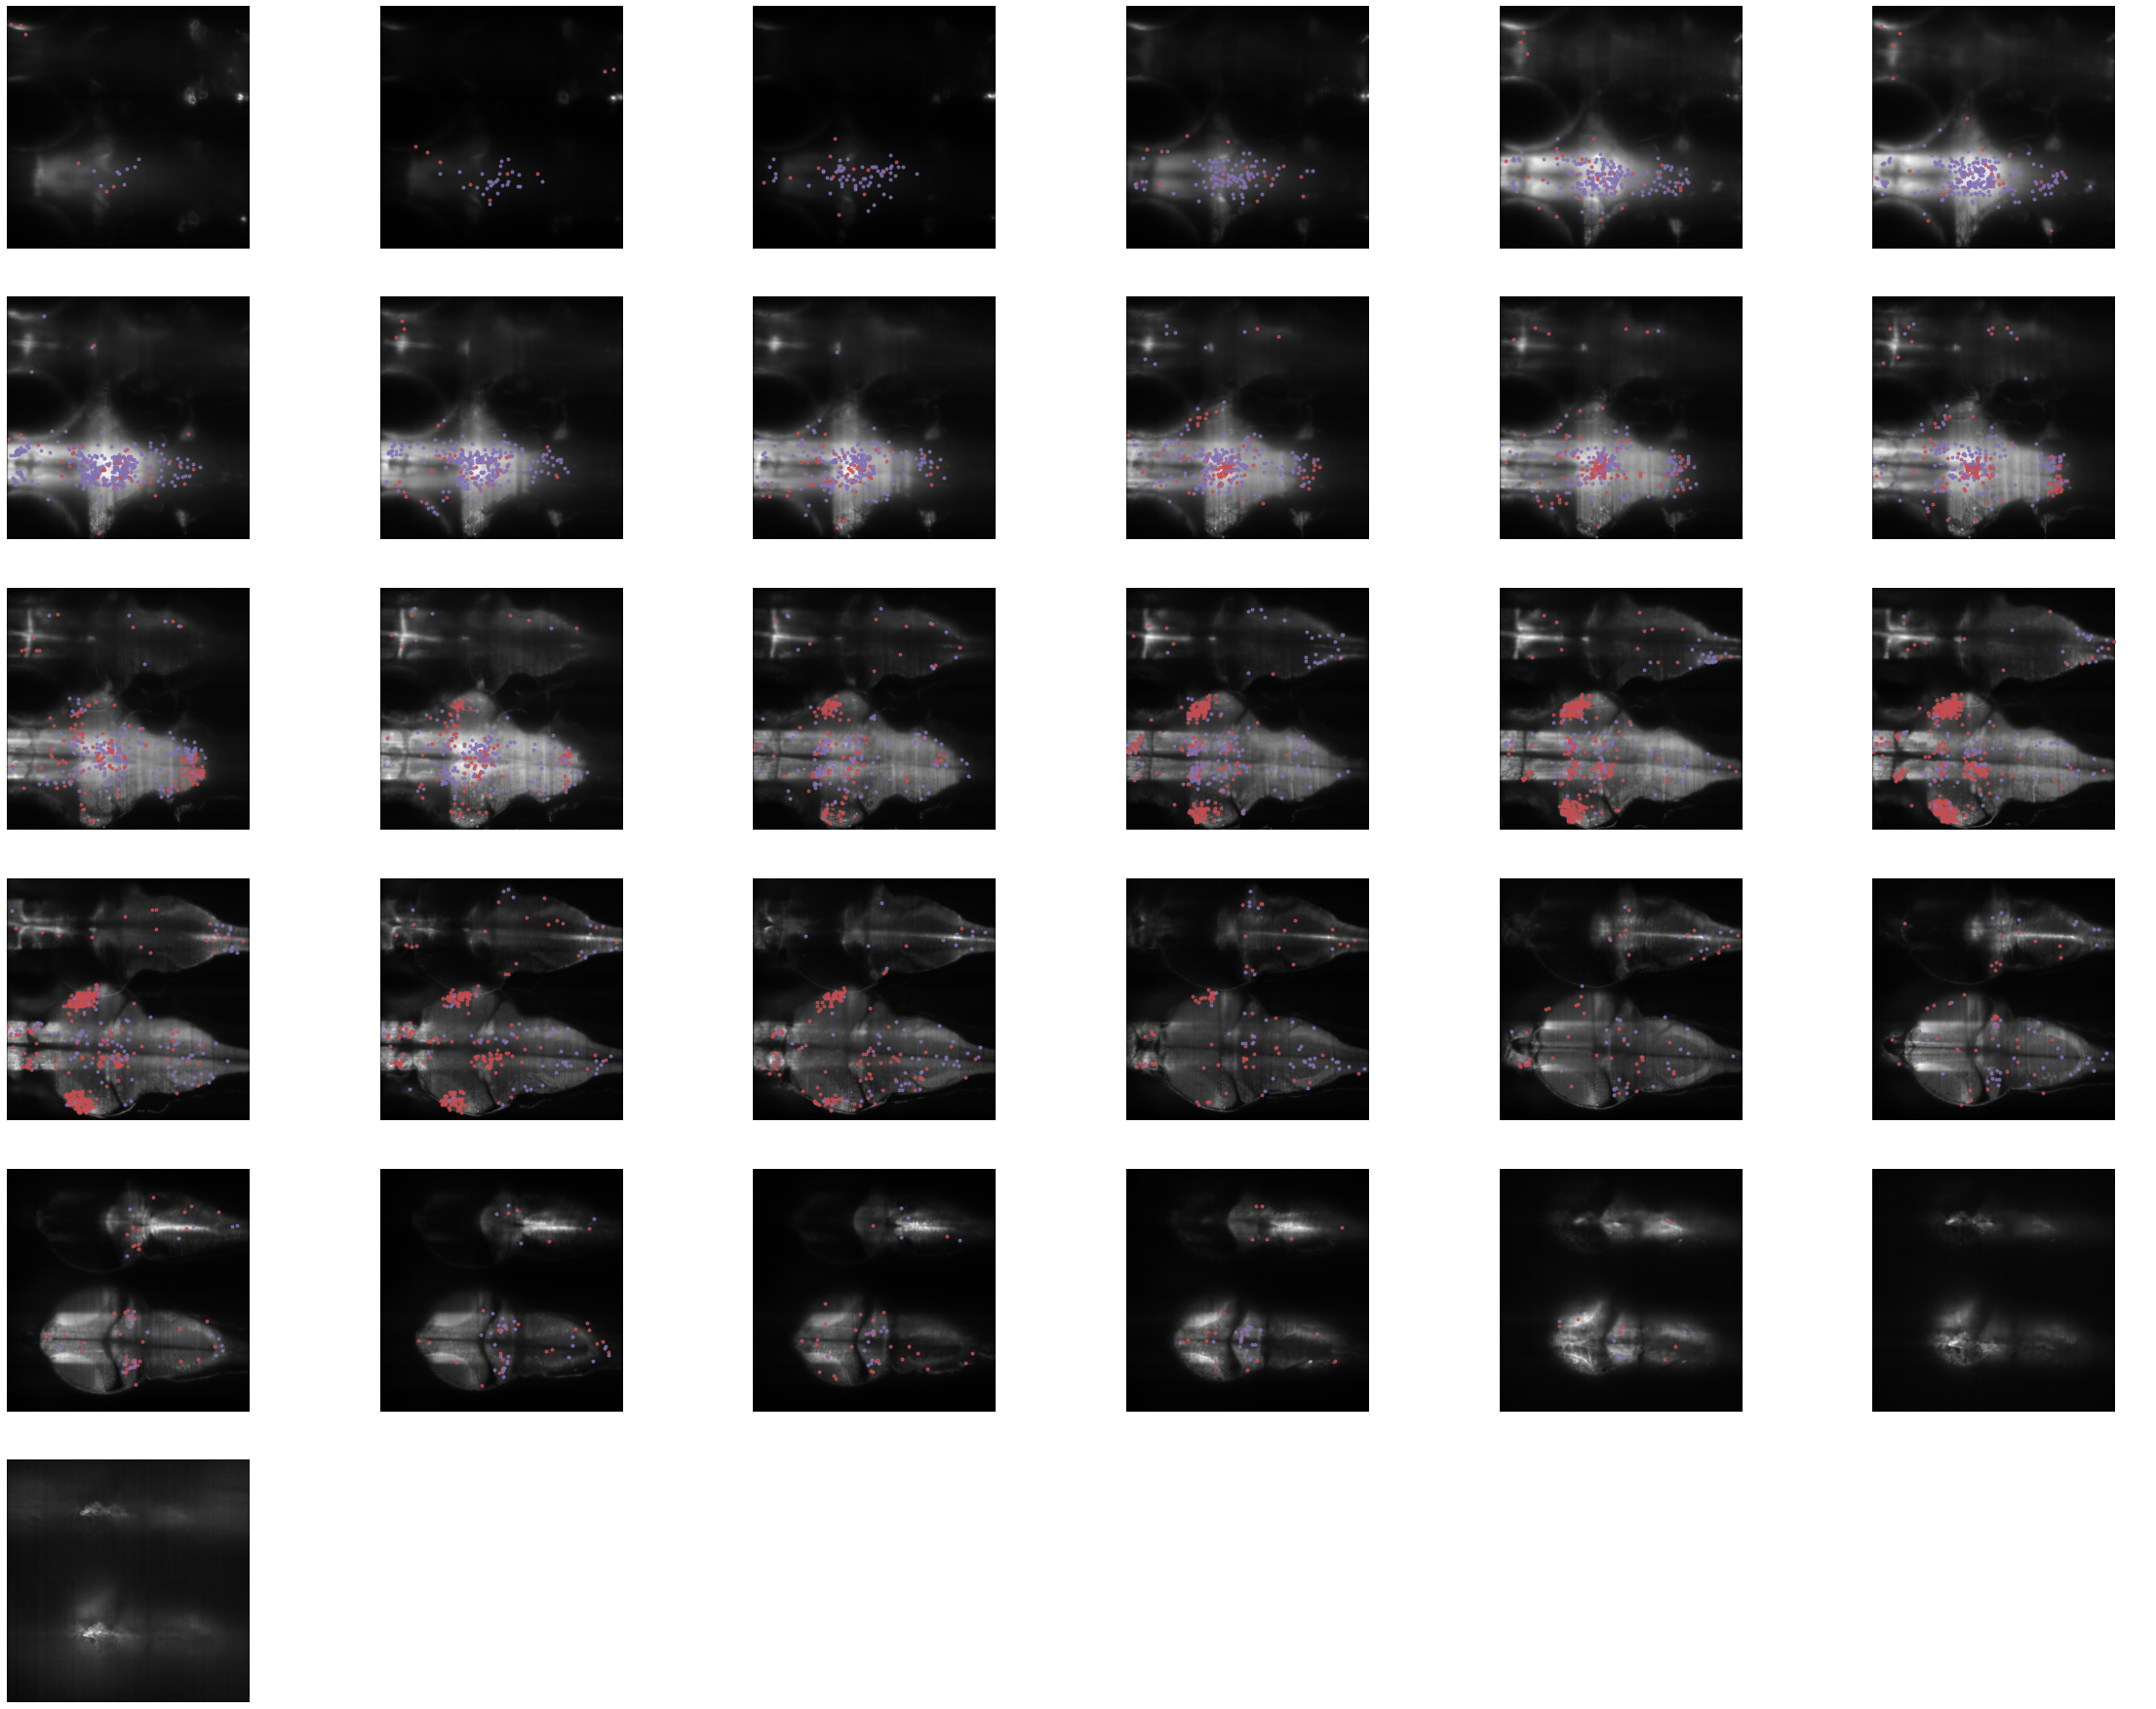

In [9]:
fig, ax = plt.subplots(6, brain_map.shape[0]//6+1, figsize=(40, 32))
ax = ax.flatten()
ppulse_ = pulse_vec_sel & pulse_ave_sel_baseline
for n_layer in range(brain_map.shape[0]):
    ax[n_layer].imshow(brain_map[n_layer], cmap='gray')
    layer_ = A_center[:, 0]==n_layer    
    pulse_ = pulse_vec_sel & pulse_ave_sel_baseline & layer_
    pulse_m_ = pulse_motor_vec_sel & layer_
    pulse_m_ = pulse_m_ & (~pulse_)
    ax[n_layer].plot(A_center[pulse_, 2], A_center[pulse_, 1], '.r', alpha=0.8)
    ax[n_layer].plot(A_center[pulse_m_, 2], A_center[pulse_m_, 1], '.m', alpha=0.8)
#     ax[n_layer].plot(A_center[pswim_, 2], A_center[pswim_, 1], '.g', alpha=0.8)
#     ax[n_layer].plot(A_center[psm_, 2], A_center[psm_, 1], '.b', alpha=0.8)
#     ax[n_layer].plot(A_center[pmix_, 2], A_center[pmix_, 1], '.y', alpha=0.8)
    
[_.set_axis_off() for _ in ax]
plt.show()

In [23]:
cell_comp_pulse_motor_stats_[1000]

array([array([0.80991144, 0.48274312, 0.67946931]),
       array([[0.95706378, 0.03005843, 0.03005843, 0.7545068 , 0.81446622,
        0.13123522, 0.192906  ],
       [0.46134159, 0.9668584 , 0.9668584 , 0.66221559, 0.29263207,
        0.99550581, 0.99336272],
       [0.87965671, 0.03049365, 0.03049365, 0.61492684, 0.63707272,
        0.15019871, 0.20019928]]),
       None,
       array([ 2.14314255e-03, -1.00428565e-04,  1.00428565e-04,  1.42915010e-03,
        2.66395463e-03,  8.18184021e-05, -3.45373913e-04]),
       array([ 0.00020483,  0.01057095, -0.01057095,  0.0036145 ,  0.00455533,
        0.01260822, -0.01054701])], dtype=object)

## Motor neurons

In [ ]:
pre_len = 2
swim_len = 4
swim_ave_sel = np.zeros(num_cells).astype('bool')
swim_vec_sel = np.zeros(num_cells).astype('bool')
swim_manova_sel = np.zeros(num_cells).astype('bool')
swim_ave_sel_baseline = np.zeros(num_cells).astype('bool')

for n in range(num_cells):
    swim_ave_sel[n] = cell_motor_stats[n][0][0]<0.05
    swim_vec_sel[n] = (cell_motor_stats[n][1][0][pre_len:]<0.05).sum()>=2
    swim_ave_sel_baseline[n] = (cell_motor_stats[n][1][2][2:]>0.05).sum()>=4
    if cell_motor_stats[n][2] is not None:
        swim_manova_sel[n] = cell_motor_stats[n][2]['Pr > F'].max()<0.05

In [ ]:
cell_motor_stats[n][3]

In [ ]:
swim_resp = np.zeros((num_cells, pre_len+swim_len))
noswim_resp = np.zeros((num_cells, pre_len+swim_len))

for n in range(num_cells):
    swim_resp[n] = cell_motor_stats[n][3]
    noswim_resp[n] = cell_motor_stats[n][4]

In [ ]:
plt.plot(np.arange(-pre_len, swim_len)/3, swim_resp[swim_vec_sel & swim_ave_sel_baseline].T, '-k')
plt.plot(np.arange(-pre_len, swim_len)/3, noswim_resp[swim_vec_sel & swim_ave_sel_baseline].T, '--r')
plt.ylabel('Swim response')
plt.xlabel('Swim onset (s)')
plt.show()

## Conditional cells

In [ ]:
pre_len = 2
swim_len = 4
mix_ave_sel = np.zeros(num_cells).astype('bool')
mix_vec_sel = np.zeros(num_cells).astype('bool')
mix_manova_sel = np.zeros(num_cells).astype('bool')
mix_ave_sel_baseline = np.zeros(num_cells).astype('bool')

for n in range(num_cells):
    mix_ave_sel[n] = cell_sm_stats[n][0][0]<0.05
    mix_vec_sel[n] = (cell_sm_stats[n][1][0][pre_len:]<0.05).sum()>=2
    mix_ave_sel_baseline[n] = (cell_sm_stats[n][1][2][2:]>0.05).sum()>=4
    if cell_sm_stats[n][2] is not None:
        mix_manova_sel[n] = cell_sm_stats[n][2]['Pr > F'].max()<0.05

In [ ]:
mix_resp = np.zeros((num_cells, pre_len+swim_len))
nomix_resp = np.zeros((num_cells, pre_len+swim_len))

for n in range(num_cells):
    mix_resp[n] = cell_sm_stats[n][3]
    nomix_resp[n] = cell_sm_stats[n][4]

In [ ]:
plt.plot(np.arange(-pre_len, swim_len)/3, mix_resp[mix_vec_sel & mix_ave_sel_baseline].T, '-k')
plt.plot(np.arange(-pre_len, swim_len)/3, nomix_resp[mix_vec_sel & mix_ave_sel_baseline].T, '--r')
plt.ylabel('Swim response')
plt.xlabel('Swim onset (s)')
plt.show()

In [ ]:
fig, ax = plt.subplots(6, brain_map.shape[0]//6+1, figsize=(40, 32))
ax = ax.flatten()
for n_layer in range(brain_map.shape[0]):
    ax[n_layer].imshow(brain_map[n_layer], cmap='gray')
    layer_ = A_center[:, 0]==n_layer    
    pulse_ = pulse_vec_sel & pulse_ave_sel_baseline & layer_
    swim_ = swim_vec_sel & swim_ave_sel_baseline & layer_
    mix_ = mix_vec_sel & mix_ave_sel_baseline & layer_
    ppulse_ = pulse_ & (~swim_) & (~mix_)
    pswim_ = swim_ & (~pulse_)
    psm_ = mix_ & (~pulse_) & (~swim_)
    pmix_ = pulse_ & swim_
    ax[n_layer].plot(A_center[ppulse_, 2], A_center[ppulse_, 1], '.r', alpha=0.8)
    ax[n_layer].plot(A_center[pswim_, 2], A_center[pswim_, 1], '.g', alpha=0.8)
    ax[n_layer].plot(A_center[psm_, 2], A_center[psm_, 1], '.b', alpha=0.8)
    ax[n_layer].plot(A_center[pmix_, 2], A_center[pmix_, 1], '.y', alpha=0.8)
    
[_.set_axis_off() for _ in ax]
plt.show()

In [ ]:
swim_resp_norm = swim_resp[:, 1:]-swim_resp[:, 1][:, None]
swim_resp_norm = swim_resp_norm/np.abs(swim_resp_norm).max(axis=-1, keepdims=True)
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=100, random_state=None).fit(swim_resp_norm)
# kmeans.labels_.min()
# for nlabel in range(100):
#     plt.plot(np.arange(-1,5)/3, swim_resp_norm[kmeans.labels_==nlabel].T, '-k')
#     plt.ylabel('Normalized pulse response')
#     plt.xlabel('Pulse onset (s)')
#     plt.show()